# Exploring the ExaMon database

This introductory notebook is a tutorial that will help you take your first steps with the examon-client, a tool that allows you to interact with the ExaMon database.

The tutorial will show you the basics of how to obtain information about the data stored in the database (metadata) and how to make real queries and obtain a dataframe as a result.

To obtain ExaMon credentials please contact:

- [Andrea Bartolini](mailto://a.bartolini@unibo.it)
- [Francesco Beneventi](mailto://francesco.beneventi@unibo.it)

**Please note:** by using your ExaMon account you are able to access data owned by CINECA and are therefore subject to the same privacy regulations that every CINECA user is required to follow.

In [ ]:
%matplotlib inline

# Mount Drive and install the examon-client
#
# Mounting Drive is an optional step but heavily suggested to have optimal
# performance in Google Colab

# (optional)
from google.colab import drive
drive.mount('/content/drive')
# Create and change to the Examon workspace folder (optional)
! mkdir -p /content/drive/MyDrive/examon_workdir
%cd /content/drive/MyDrive/examon_workdir

# Install (required)
! pip install https://github.com/fbeneventi/releases/releases/latest/download/examon-client.zip

Mounted at /content/drive
/content/drive/MyDrive/examon_workdir
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.9/353.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
  Created wheel for examon-client: filename=examon_client-0.4.0b1-py3-none-any.whl size=18778 sha256=343c1a6258da8c47ece95cb0756ca482f00ed6528ac31662e7d26e38f29ead11
  Stored in directory: /root/.cache/pip/wheels/80/40/5e/6415332cf365491ebec39e418f3ddfaf3cea94b01e5bc54f79
Successfully built examon-client


### Examon setup

In [ ]:
# Init steps

import os
import getpass
import numpy as np
import pandas as pd
from examon.examon import Client, ExamonQL

# Connect
USER = input('username:')
print('password:')
PWD = getpass.getpass()
ex = Client('examon.cineca.it', port='3002', user=USER, password=PWD, verbose=False, proxy=True)
print('Creating the local metadata cache (one-time task). Please wait ...')
sq = ExamonQL(ex)

username:admin
password:
··········
Creating the local metadata cache (one-time task). Please wait ...


### Metric list
To start with Examon, it is recommended that you first get a list of the sensors contained in the database. The initial object (ExamonQL) instantiation will do a full db scan checking for all the metrics tags. This will happen only the first time since the client uses caches where possible to save the database bandwith.

In [ ]:
display(pd.DataFrame(sq.metric_list))


name
0                  0_0
1                  12V
2     1U_Stg_HDD0_Pres
3     1U_Stg_HDD1_Pres
4     1U_Stg_HDD2_Pres
...                ...
2318         vm_pgpgin
2319        vm_pgpgout
2320          vm_vmeff
2321          wind_deg
2322        wind_speed

[2323 rows x 1 columns]

### Tag Keys
Each metric in the database comes with a set of tags (key;value) useful for filtering during queries.
It is possible to obtain from the database all the possible tags (keys) associated to a specific metric.


In [ ]:
df = sq.DESCRIBE() \
    .execute()

display(df)

name                                           tag keys
0                  0_0  [chnl, cluster, node, org, plugin, rack, slot,...
1     1U_Stg_HDD1_Pres   [chnl, cluster, health, node, org, plugin, type]
2                  12V  [chnl, cluster, health, node, org, plugin, typ...
3     1U_Stg_HDD0_Pres   [chnl, cluster, health, node, org, plugin, type]
4     1U_Stg_HDD3_Pres   [chnl, cluster, health, node, org, plugin, type]
...                ...                                                ...
2317     vm_pgmajfault  [chnl, cluster, gcluster, group, node, org, pl...
2318             state  [chnl, cluster, description, host_group, nagio...
2319        swap_total  [chnl, cluster, gcluster, group, node, org, pl...
2320         swap_free  [chnl, cluster, gcluster, group, node, org, pl...
2321   PS1_Temperature  [chnl, cluster, health, node, org, part, plugi...

[2322 rows x 2 columns]

The database contains this number of valid metric names:

In [ ]:
df.shape[0]

2322

To get an entry from the table:

In [ ]:
df[df.name == 'Ambient_Temp']['tag keys'].values[0]

['chnl', 'cluster', 'health', 'node', 'org', 'part', 'plugin', 'type', 'units']

### Tag values
It is possible to obtain all the possible values of all the tag keys of a given metric:

In [ ]:
df = sq.DESCRIBE(metric='CPU_Utilization') \
    .execute()

display(df)

name  tag key                                         tag values
0  CPU_Utilization     chnl                                             [data]
1  CPU_Utilization  cluster                                 [galileo, marconi]
2  CPU_Utilization   health                                               [ok]
3  CPU_Utilization     node  [node001, node002, node003, node004, node005, ...
4  CPU_Utilization      org                                           [cineca]
5  CPU_Utilization     part                                     [knl, skylake]
6  CPU_Utilization   plugin                          [confluent_pub, ipmi_pub]
7  CPU_Utilization     type                                            [Other]

### All the possible values of a given tag key
In this example we will search all the plugin names currently available in the Examon database.

In [ ]:
df = sq.DESCRIBE(tag_key = 'plugin') \
    .execute()

display(df)

tag values
0                     ipmi_pub
1                confluent_pub
2                   vertiv_pub
3                schneider_pub
4                      pmu_pub
5                   logics_pub
6   predictive_maintenance_pub
7                  ganglia_pub
8                    slurm_pub
9                   nvidia_pub
10                 weather_pub
11                   dstat_pub
12               examon-ai_pub
13                  nagios_pub

### Metrics having a given tag value
Assume that we need to know the list of the metrics having a given tag (key, value).
In this example, we get the list of all metrics inserted into the db by the 'confluent_pub' examon plugin.

In [ ]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='confluent_pub') \
    .execute()

display(df)

name
0                 12V
1    1U_Stg_HDD0_Pres
2    1U_Stg_HDD1_Pres
3    1U_Stg_HDD2_Pres
4    1U_Stg_HDD3_Pres
..                ...
380             Vcpu2
381     Voltage_Fault
382     XCC_Corrupted
383    XCC_SWitchover
384    XCC_Switchover

[385 rows x 1 columns]

#### Metrics valid only for Marconi skaylake nodes
Some metrics are valid (exist) only for a subset of the monitored resources. In this example we will search for the metrics collected by the 'confluent_pub' plugin and for the 'marconi' cluster and for only the 'skylake' partition. The 'JOIN' command let you 'intersect' ('inner' join) the results of each DESCRIBE command.

In [ ]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='confluent_pub') \
    .DESCRIBE(tag_key = 'cluster', tag_value='marconi') \
    .DESCRIBE(tag_key = 'part', tag_value='skylake') \
    .JOIN(how='inner') \
    .execute()

display(df)

name
0          All_CPUs
1         All_DIMMs
2     All_PCI_Error
3      Ambient_Temp
4           Aux_Log
..              ...
150    TPM_TCM_Lock
151  TXT_ACM_Module
152   XCC_Corrupted
153  XCC_SWitchover
154  XCC_Switchover

[155 rows x 1 columns]

#### Metrics collected by the 'nagios_pub' plugin

In [ ]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='nagios_pub') \
    .execute()

display(df)

name
0  hostscheduleddowtimecomments
1                 plugin_output
2                         state

Check the tags available for the 'plugin_output' metric

In [ ]:
df = sq.DESCRIBE(metric='plugin_output') \
    .execute()

display(df)

name        tag key  \
0   plugin_output           chnl   
1   plugin_output        cluster   
2   plugin_output    description   
3   plugin_output     host_group   
4   plugin_output  nagiosdrained   
5   plugin_output           node   
6   plugin_output            org   
7   plugin_output         plugin   
8   plugin_output           rack   
9   plugin_output           slot   
10  plugin_output          state   
11  plugin_output     state_type   

                                           tag values  
0                                              [data]  
1                      [galileo, marconi, marconi100]  
2   [EFGW_cluster::status::availability, EFGW_clus...  
3   [compute, compute,cincompute, containers, cumu...  
4                                              [0, 1]  
5   [aggregation-mgt, comlab01, deepops, dgx01, dg...  
6                                            [cineca]  
7                                        [nagios_pub]  
8   [201, 202, 205, 206, 207, 208, 209, 210, 211, ...  
9   [01, 02, 03, 04, 05, 06, 07, 08, 09, 1, 10, 11...  
10                                       [0, 1, 2, 3]  
11                                             [0, 1]

The 'description' tag may have some hints about the services monitored by this plugin. Lets check it:

In [ ]:
df[df['tag key'] == 'description']['tag values'].values[0]


['EFGW_cluster::status::availability',
 'EFGW_cluster::status::criticality',
 'EFGW_cluster::status::internal',
 'GALILEO_cluster::status::availability',
 'GALILEO_cluster::status::criticality',
 'GALILEO_cluster::status::internal',
 'afs::blocked_conn::status',
 'afs::bosserver::status',
 'afs::ptserver::status',
 'afs::space::status',
 'afs::vlserver::status',
 'alive::ping',
 'backup::afs::status',
 'backup::eufus_gw::status',
 'backup::local::status',
 'backup::masters::status',
 'backup::shared::status',
 'batchs::JobsH',
 'batchs::client',
 'batchs::client::serverrespond',
 'batchs::client::state',
 'batchs::manager',
 'batchs::manager::state',
 'bmc::events',
 'cluster::status::availability',
 'cluster::status::criticality',
 'cluster::status::internal',
 'cluster::status::wattage',
 'cluster::us::availability',
 'cluster::us::criticality',
 'container::check::health',
 'container::check::internal',
 'container::check::mounts',
 'core::total',
 'crm::resources::m100',
 'crm::sta

Lets see if there are services in a 'critical' state (2) and which node affect:

In [ ]:
data = sq.SELECT('node','cluster','description','state') \
    .FROM('plugin_output') \
    .WHERE(plugin='nagios_pub', state='2') \
    .TSTART(30, 'minutes') \
    .execute()

display(data.df_table.head(10))

In [ ]:
data.df_table.shape

(8548, 7)

## Query Examples
### 1) Marconi Skylake Power Consumption


In [ ]:
data = sq.SELECT('cluster','part','node') \
    .FROM('Sys_Power') \
    .WHERE(cluster='marconi', part='skylake') \
    .TSTART(30, 'minutes') \
    .AGGRBY('avg', sampling_value=1, sampling_unit='minutes') \
    .execute()

display(data.df_table.head())

In [ ]:
data.df_table.shape

(46503, 6)

Check the number of nodes ('node' tag):

In [ ]:
display(data.df_table.nunique())

timestamp      88
value          37
name            1
cluster         1
part            1
node         3121
dtype: int64

#### Time Series Format
Reshape the 'df_table' to a time series table: first column (index) = timestamp, remaining columns = nodes power vectors.

In [ ]:
data.to_series(flat_index=True, interp='time', dropna=True, columns=['node'])

display(data.df_ts.head())

node                              r129c01s01  r129c01s02  r129c01s03  \
timestamp                                                              
2023-09-22 17:49:00.061000+02:00       120.0       120.0       120.0   
2023-09-22 17:50:00.027000+02:00       120.0       120.0       120.0   
2023-09-22 17:50:00.031000+02:00       120.0       120.0       120.0   
2023-09-22 17:51:00.027000+02:00       120.0       120.0       120.0   
2023-09-22 17:51:00.031000+02:00       120.0       120.0       120.0   

node                              r129c01s04  r129c02s01  r129c02s02  \
timestamp                                                              
2023-09-22 17:49:00.061000+02:00       120.0       120.0       120.0   
2023-09-22 17:50:00.027000+02:00       120.0       120.0       120.0   
2023-09-22 17:50:00.031000+02:00       120.0       120.0       120.0   
2023-09-22 17:51:00.027000+02:00       120.0       120.0       120.0   
2023-09-22 17:51:00.031000+02:00       120.0       120.0       120.0   

node                              r129c02s03  r129c02s04  r129c03s01  \
timestamp                                                              
2023-09-22 17:49:00.061000+02:00       120.0  134.996730  282.488555   
2023-09-22 17:50:00.027000+02:00       120.0  130.000625  265.002187   
2023-09-22 17:50:00.031000+02:00       120.0  130.000292  265.001021   
2023-09-22 17:51:00.027000+02:00       120.0  125.001687  247.505905   
2023-09-22 17:51:00.031000+02:00       120.0  125.001354  247.504739   

node                              r129c03s02  ...  r183c14s03  r183c14s04  \
timestamp                                     ...                           
2023-09-22 17:49:00.061000+02:00  262.508175  ...  270.001292  259.998708   
2023-09-22 17:50:00.027000+02:00  274.998438  ...  272.499865  257.500135   
2023-09-22 17:50:00.031000+02:00  274.999271  ...  272.500031  257.499969   
2023-09-22 17:51:00.027000+02:00  287.495782  ...  274.999854  255.000146   
2023-09-22 17:51:00.031000+02:00  287.496615  ...  275.000021  254.999979   

node                              r183c15s01  r183c15s02  r183c15s03  \
timestamp                                                              
2023-09-22 17:49:00.061000+02:00  319.988375  309.997417  299.997417   
2023-09-22 17:50:00.027000+02:00  297.501219  305.000271  295.000271   
2023-09-22 17:50:00.031000+02:00  297.499719  304.999938  294.999938   
2023-09-22 17:51:00.027000+02:00  275.001313  300.000292  290.000292   
2023-09-22 17:51:00.031000+02:00  274.999813  299.999958  289.999958   

node                              r183c15s04  r183c16s01  r183c16s02  \
timestamp                                                              
2023-09-22 17:49:00.061000+02:00  329.989667       290.0  249.998708   
2023-09-22 17:50:00.027000+02:00  310.001083       290.0  247.500135   
2023-09-22 17:50:00.031000+02:00  309.999750       290.0  247.499969   
2023-09-22 17:51:00.027000+02:00  290.001167       290.0  245.000146   
2023-09-22 17:51:00.031000+02:00  289.999833       290.0  244.999979   

node                              r183c16s03  r183c16s04  
timestamp                                                 
2023-09-22 17:49:00.061000+02:00  260.005167  329.997417  
2023-09-22 17:50:00.027000+02:00  269.999458  325.000271  
2023-09-22 17:50:00.031000+02:00  270.000125  324.999938  
2023-09-22 17:51:00.027000+02:00  279.999417  320.000292  
2023-09-22 17:51:00.031000+02:00  280.000083  319.999958  

[5 rows x 3121 columns]

### Skylake partition total power consuption
Total average power in the previous 30 minutes

In [ ]:
data.df_ts.mean().sum()

859025.39826763

### 2) Looking for failures

First look for metrics with critical status. Use the intersection: search metrics having...

In [ ]:
df = sq.DESCRIBE(tag_key = 'plugin', tag_value='confluent_pub') \
    .DESCRIBE(tag_key = 'health', tag_value='critical') \
    .DESCRIBE(tag_key = 'part', tag_value='skylake') \
    .JOIN() \
    .execute()

display(df)

name
0          All_DIMMs
1      All_PCI_Error
2       Ambient_Temp
3       CMOS_Battery
4          CPU_1_DTS
..               ...
61      PSU2_Failure
62   PSU2_IN_Failure
63    Power_Supply_1
64    Power_Supply_2
65  SysBrd_Vol_Fault

[66 rows x 1 columns]

For example, lets check for **CPU_1_Overtemp** metric over the last year to find the affected nodes and the time period

In [ ]:
# show the tags to filter
df = sq.DESCRIBE(metric='CPU_1_Overtemp') \
    .execute()

display(df)

name  tag key                                         tag values
0  CPU_1_Overtemp     chnl                                             [data]
1  CPU_1_Overtemp  cluster                                 [galileo, marconi]
2  CPU_1_Overtemp   health                    [critical, failed, ok, warning]
3  CPU_1_Overtemp     node  [r054c02s01, r054c02s02, r054c02s03, r054c02s0...
4  CPU_1_Overtemp      org                                           [cineca]
5  CPU_1_Overtemp     part                                     [knl, skylake]
6  CPU_1_Overtemp   plugin                                    [confluent_pub]
7  CPU_1_Overtemp     type                                      [Temperature]

In [ ]:
# query
data = sq.SELECT('*') \
    .FROM('CPU_1_Overtemp') \
    .WHERE(part='skylake', health='critical') \
    .TSTART(1,'years') \
    .execute()

display(data.df_table.head())

timestamp     value            name  chnl  cluster  \
0 2022-12-13 14:05:00.032000+01:00  critical  CPU_1_Overtemp  data  marconi   
1 2023-09-14 11:53:00.038000+02:00  critical  CPU_1_Overtemp  data  marconi   
2 2023-05-26 11:47:00.151000+02:00  critical  CPU_1_Overtemp  data  marconi   
3 2023-05-26 23:47:00.034000+02:00  critical  CPU_1_Overtemp  data  marconi   
4 2023-05-30 13:16:00.034000+02:00  critical  CPU_1_Overtemp  data  marconi   

     health        node     org     part         plugin         type  
0  critical  r135c11s01  cineca  skylake  confluent_pub  Temperature  
1  critical  r137c11s03  cineca  skylake  confluent_pub  Temperature  
2  critical  r138c02s02  cineca  skylake  confluent_pub  Temperature  
3  critical  r138c02s02  cineca  skylake  confluent_pub  Temperature  
4  critical  r138c02s02  cineca  skylake  confluent_pub  Temperature

Show the first value of each node (when the anomaly appeared for the first time)

In [ ]:
display(data \
        .df_table \
        .groupby('node') \
        .first() \
        .sort_values(by=['timestamp'],ascending=False) \
        .head())

timestamp     value            name  chnl  \
node                                                                          
r137c11s03 2023-09-14 11:53:00.038000+02:00  critical  CPU_1_Overtemp  data   
r143c04s03 2023-06-22 15:27:00.217000+02:00  critical  CPU_1_Overtemp  data   
r143c11s01 2023-06-13 19:40:00.031000+02:00  critical  CPU_1_Overtemp  data   
r138c13s02 2023-06-01 15:51:00.037000+02:00  critical  CPU_1_Overtemp  data   
r138c02s02 2023-05-26 11:47:00.151000+02:00  critical  CPU_1_Overtemp  data   

            cluster    health     org     part         plugin         type  
node                                                                        
r137c11s03  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c04s03  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c11s01  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r138c13s02  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r138c02s02  marconi  critical  cineca  skylake  confluent_pub  Temperature

Show the last value of each node (when the anomaly was removed/solved)

In [ ]:
display(data \
        .df_table \
        .groupby('node') \
        .last() \
        .sort_values(by=['timestamp'],ascending=False) \
        .head())

timestamp     value            name  chnl  \
node                                                                          
r138c13s02 2023-09-17 22:29:00.175000+02:00  critical  CPU_1_Overtemp  data   
r137c11s03 2023-09-14 11:53:00.038000+02:00  critical  CPU_1_Overtemp  data   
r143c02s04 2023-09-02 08:09:00.031000+02:00  critical  CPU_1_Overtemp  data   
r143c04s03 2023-06-22 15:47:00.162000+02:00  critical  CPU_1_Overtemp  data   
r143c11s01 2023-06-14 06:02:00.027000+02:00  critical  CPU_1_Overtemp  data   

            cluster    health     org     part         plugin         type  
node                                                                        
r138c13s02  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r137c11s03  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c02s04  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c04s03  marconi  critical  cineca  skylake  confluent_pub  Temperature  
r143c11s01  marconi  critical  cineca  skylake  confluent_pub  Temperature

For example, node 'r145c10s04' showed a crtical status for the CPU1 temperature starting from 2019-09-23 16:54 to 2019-09-26 04:27. Lets check it plotting that range plus 1 hour before and after:

<Axes: xlabel='timestamp'>

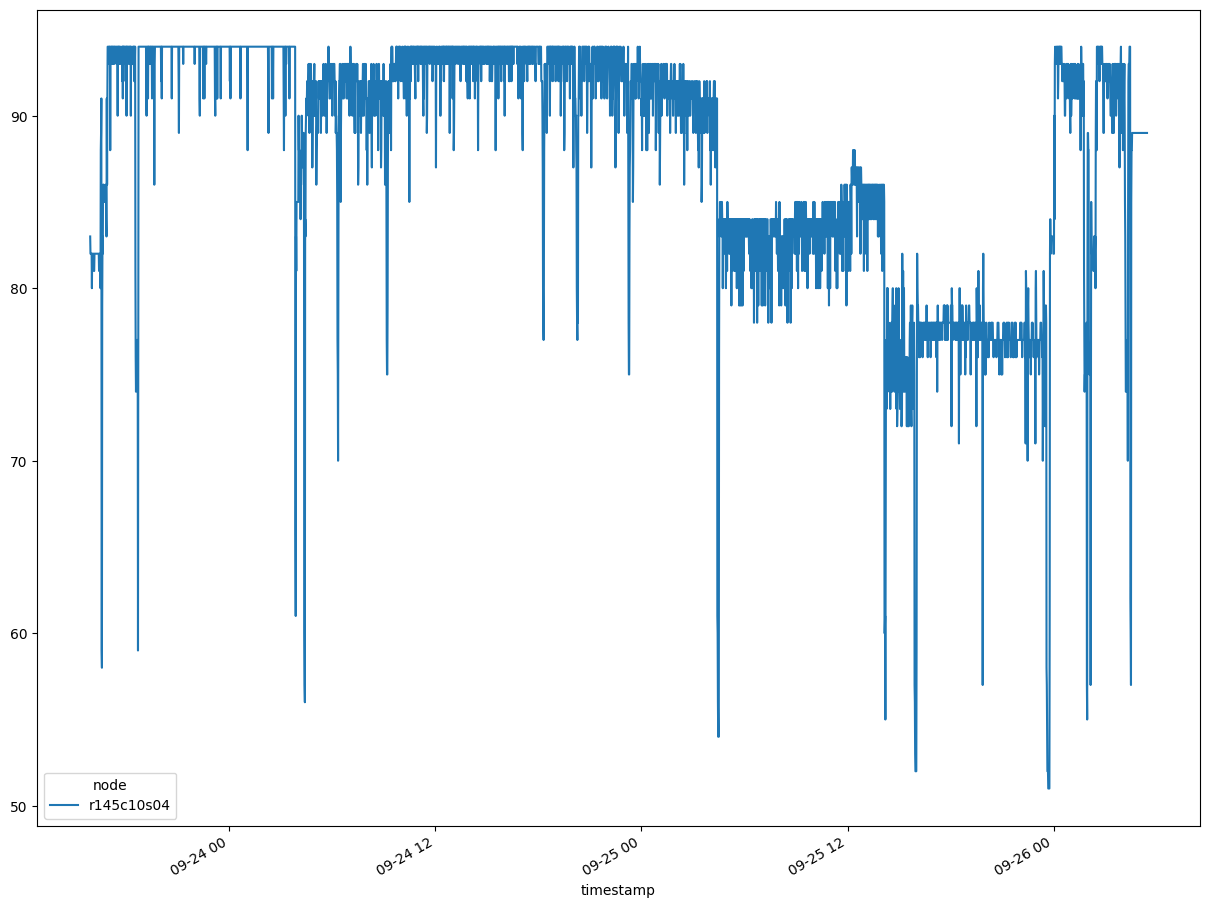

In [ ]:
data = sq.SELECT('*') \
    .FROM('CPU_1_Temp') \
    .WHERE(node='r145c10s04') \
    .TSTART('23-09-2019 15:54:00') \
    .TSTOP('26-09-2019 05:27:00') \
    .execute()

data.to_series(flat_index=True, interp='time', dropna=True, columns=['node']).df_ts.plot(figsize=[15,12])

Where we can see values greater than 90 °C for the CPU1

## Job scheduler data
<div class="alert alert-warning">
<b>NOTE</b> This is an experimental feature and is subject to change in future versions.
</div>

Currently the job scheduler data is collected as per-job data in plain Cassandra tables. The available tables in the database are
* **job_info_galileo**: Galileo jobs data
* **job_info_marconi**: Marconi jobs data

This is a description of the data currently stored (where available) for each executed job:

| Table fields          | Description                                                                          |
|-----------------------|--------------------------------------------------------------------------------------|
| account               | charge to specified account                                                          |
| accrue_time           | time job is eligible for running                                                     |
| admin_comment         | administrator's arbitrary comment                                                    |
| alloc_node            | local node and system id making the resource allocation                              |
| alloc_sid             | local sid making resource alloc                                                      |
| array_job_id          | job_id of a job array or 0 if N/A                                                    |
| array_max_tasks       | Maximum number of running tasks                                                      |
| array_task_id         | task_id of a job array                                                               |
| array_task_str        | string expression of task IDs in this record                                         |
| assoc_id              | association id for job                                                               |
| batch_features        | features required for batch script's node                                            |
| batch_flag            | 1 if batch: queued job with script                                                   |
| batch_host            | name of host running batch script                                                    |
| billable_tres         | billable TRES cache. updated upon resize                                             |
| bitflags              | Various job flags                                                                    |
| boards_per_node       | boards per node required by job                                                      |
| burst_buffer          | burst buffer specifications                                                          |
| burst_buffer_state    | burst buffer state info                                                              |
| command               | command to be executed, built from submitted  job's argv and NULL for salloc command |
| comment               | arbitrary comment                                                                    |
| contiguous            | 1 if job requires contiguous nodes                                                   |
| core_spec             | specialized core count                                                               |
| cores_per_socket      | cores per socket required by job                                                     |
| cpu_freq_gov          | cpu frequency governor                                                               |
| cpu_freq_max          | Maximum cpu frequency                                                                |
| cpu_freq_min          | Minimum cpu frequency                                                                |
| cpus_alloc_layout     | map: list of cpu allocated per node                                                  |
| cpus_allocated        | map: number of cpu allocated per node                                                 |
| cpus_per_task         | number of processors required for each task                                          |
| cpus_per_tres         | semicolon delimited list of TRES=# values                                            |
| dependency            | synchronize job execution with other jobs                                            |
| derived_ec            | highest exit code of all job steps                                                   |
| eligible_time         | time job is eligible for running                                                     |
| end_time              | time of termination, actual or expected                                              |
| exc_nodes             | comma separated list of excluded nodes                                               |
| exit_code             | exit code for job (status from wait call)                                            |
| features              | comma separated list of required features                                            |
| group_id              | group job submitted as                                                               |
| job_id                | job ID                                                                               |
| job_state             | state of the job, see enum job_states                                                |
| last_sched_eval       | last time job was evaluated for scheduling                                           |
| licenses              | licenses required by the job                                                         |
| max_cpus              | maximum number of cpus usable by job                                                 |
| max_nodes             | maximum number of nodes usable by job                                                |
| mem_per_cpu           | boolean                                                                              |
| mem_per_node          | boolean                                                                              |
| mem_per_tres          | semicolon delimited list of TRES=# values                                            |
| min_memory_cpu        | minimum real memory required per allocated CPU                                       |
| min_memory_node       | minimum real memory required per node                                                |
| name                  | name of the job                                                                      |
| network               | network specification                                                                |
| nice                  | requested priority change                                                            |
| nodes                 | list of nodes allocated to job                                                       |
| ntasks_per_board      | number of tasks to invoke on each board                                              |
| ntasks_per_core       | number of tasks to invoke on each core                                               |
| ntasks_per_core_str   | number of tasks to invoke on each core  as string                                    |
| ntasks_per_node       | number of tasks to invoke on each node                                               |
| ntasks_per_socket     | number of tasks to invoke on each socket                                             |
| ntasks_per_socket_str | number of tasks to invoke on each socket as string                                   |
| num_cpus              | minimum number of cpus required by job                                               |
| num_nodes             | minimum number of nodes required by job                                              |
| partition             | name of assigned partition                                                           |
| pn_min_cpus           | minimum # CPUs per node, default=0                                                   |
| pn_min_memory         | minimum real memory per node, default=0                                              |
| pn_min_tmp_disk       | minimum tmp disk per node, default=0                                                 |
| power_flags           | power management flags,  see SLURM_POWER_FLAGS_                                      |
| pre_sus_time          | time job ran prior to last suspend                                                   |
| preempt_time          | preemption signal time                                                               |
| priority              | relative priority of the job, 0=held, 1=required nodes DOWN/DRAINED                  |
| profile               | Level of acct_gather_profile {all / none}                                            |
| qos                   | Quality of Service                                                                   |
| reboot                | node reboot requested before start                                                   |
| req_nodes             | comma separated list of required nodes                                               |
| req_switch            | Minimum number of switches                                                           |
| requeue               | enable or disable job requeue option                                                 |
| resize_time           | time of latest size change                                                           |
| restart_cnt           | count of job restarts                                                                |
| resv_name             | reservation name                                                                     |
| run_time              | job run time (seconds)                                                               |
| run_time_str          | job run time (seconds) as string                                                     |
| sched_nodes           | list of nodes scheduled to be used for job                                           |
| shared                | 1 if job can share nodes with other jobs                                             |
| show_flags            | conveys level of details requested                                                   |
| sockets_per_board     | sockets per board required by job                                                    |
| sockets_per_node      | sockets per node required by job                                                     |
| start_time            | time execution begins, actual or expected                                            |
| state_reason          | reason job still pending or failed, see slurm.h:enum job_state_reason                |
| std_err               | pathname of job's stderr file                                                        |
| std_in                | pathname of job's stdin file                                                         |
| std_out               | pathname of job's stdout file                                                        |
| submit_time           | time of job submission                                                               |
| suspend_time          | time job last suspended or resumed                                                   |
| system_comment        | slurmctld's arbitrary comment                                                        |
| threads_per_core      | threads per core required by job                                                     |
| time_limit            | maximum run time in minutes or INFINITE                                              |
| time_limit_str        | maximum run time in minutes or INFINITE as string                                    |
| time_min              | minimum run time in minutes or INFINITE                                              |
| tres_alloc_str        | tres used in the job as string                                                       |
| tres_bind             | Task to TRES binding directives                                                      |
| tres_freq             | TRES frequency directives                                                            |
| tres_per_job          | semicolon delimited list of TRES=# values                                            |
| tres_per_node         | semicolon delimited list of TRES=# values                                            |
| tres_per_socket       | semicolon delimited list of TRES=# values                                            |
| tres_per_task         | semicolon delimited list of TRES=# values                                            |
| tres_req_str          | tres reqeusted in the job as string                                                  |
| user_id               | user the job runs as                                                                 |
| wait4switch           | Maximum time to wait for minimum switches                                            |
| wckey                 | wckey for job                                                                        |
| work_dir              | pathname of working directory                                                        |

### Query examples
Queries can be executed as usual but paying attention to the following limitations:

* both TSTART and TSTOP statements must be specified
* the date currently is supported only in the string format
* pushdown filters (executed on the datastore) are available only for a subset of table columns:
 * job_id
 * job_state
 * account
 * user_id
 * node (keys of __cpus_alloc_layout__ table column)

In [ ]:
# Ask for all galileo jobs executed between '28-09-2019 08:09:00' and '30-09-2019 08:09:00'

import json

# Setup
sq.jc.JOB_TABLES.add('job_info_galileo')

data = sq.SELECT('*') \
    .FROM('job_info_galileo') \
    .TSTART('28-09-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute()

df = pd.DataFrame(json.loads(data))
df.head()

In [ ]:
df.shape

In [ ]:
# Ask for all galileo jobs executed between '28-09-2019 08:09:00' and '30-09-2019 08:09:00',
# allocated on node "r038c04s03"

data = sq.SELECT('*') \
    .FROM('job_info_galileo') \
    .WHERE(node='r038c04s03') \
    .TSTART('28-09-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute()

df = pd.DataFrame(json.loads(data))
df.head()

In [ ]:
df.shape

In [ ]:
# Ask for all galileo jobs executed between '28-09-2019 08:09:00' and '30-09-2019 08:09:00',
# allocated on node "r038c04s03" and job_state = 'FAILED'

data = sq.SELECT('*') \
    .FROM('job_info_galileo') \
    .WHERE(node='r038c04s03', job_state='FAILED') \
    .TSTART('28-09-2019 08:09:00') \
    .TSTOP('30-09-2019 08:09:00') \
    .execute()

df = pd.DataFrame(json.loads(data))
df.head()

In [ ]:
df.shape

In [ ]:
# Marconi100 jobs

# Setup for Marconi100
sq.jc.JOB_TABLES.add('job_info_marconi100')

data = sq.SELECT('*') \
    .FROM('job_info_marconi100') \
    .TSTART('28-09-2020 08:09:00') \
    .TSTOP('30-09-2020 08:09:00') \
    .execute()

df = pd.read_json(data)
df.head()

In [ ]:
df.shape

(11614, 110)

#### Asynchronous queries

In case of big queries it can be useful to use the asynchronous mode (available from client version v0.4.0)

In [ ]:
import time

# One month of data
tstart = '01-04-2021 00:00:00'
tstop = '30-04-2021 00:00:00'

t0 = time.time()
data = sq.SELECT('*') \
    .FROM('job_info_marconi100') \
    .TSTART(tstart) \
    .TSTOP(tstop) \
    .execute_async()

print('Elapsed Time: %f seconds' % (time.time() - t0))

df = pd.read_json(data)
df.head()

In [ ]:
df.shape

(109608, 110)